In [34]:
import json 
import os
import logging 
import concurrent 
import asyncio 
from itertools import chain 
from datetime import date, datetime 

from typing import List 
from pprint import PrettyPrinter
from subgrounds import Subgrounds
from subgrounds.pagination import ShallowStrategy
from IPython.display import HTML, display
from web3 import Web3 
from functools import partial 
from concurrent.futures import ThreadPoolExecutor
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport

import pandas as pd 
import numpy as np 
import altair as alt 
import missingno as miss

# logging.basicConfig(level=logging.INFO) 

pp = PrettyPrinter().pprint

In [2]:
URL_INFURA = 'https://mainnet.infura.io/v3/856c3834f317452a82e25bb06e04de18'
w3 = Web3(Web3.HTTPProvider(URL_INFURA))

### Bribes Analysis 

We are interested in analyzing the impact of bribes through 

- Votium (voting power vlCVX, incentives in FXS) 
- Pitch 
- bribe.crv.finance 
- Hidden Hand 
- Aura 

that incentivize liquidity in liquidity pools that contain FRAX. To start, we are working with the following subset of pools that exist on curve. 
- Metapools (stable / non-stable). 
- Frax BP
- Frax:3crv

The following metrics are of interest

- \\$ Bribes spent per pool (broken down by platform and incentive type)  
- \\$ Liquidity per pool (broken into Frax and non-Frax components) 

Once we have both the liquidity and bribe information, we can try to answer these questions
- Where are bribe dollars best spent? 
- How does the Frax protocol optimize its bribing strategy in order to maximize the amount of liquidity within it's pools? 

In [3]:
def ddf(df):
    display(HTML(df.to_html()))
    
    
def remove_prefix(df: pd.DataFrame, prefix: str):
    # Remove a prefix from all columns 
    cols = [c for c in df.columns]
    for i, c in enumerate(cols): 
        if c.startswith(prefix): 
            cols[i] = c[len(prefix):]
    df.columns = cols 
    return df 

def remove_prefixes(df: pd.DataFrame, prefixes: List[str]):
    for p in prefixes: 
        df = remove_prefix(df, p)
    return df 

def zip_dfs(dfs, col_names): 
    data = dfs[0]
    for i, c in enumerate(col_names): 
        data = data.merge(dfs[i+1][[c]], how='left', left_index=True, right_index=True)
    return data

def query_attrs(query, attrs):
    return sg.query_df([getattr(query, a) for a in attrs], pagination_strategy=ShallowStrategy) 


async def graphql_execute(
    query, 
    variable_values=None, 
    paginate=False, 
    page_size=10000, 
    page_size_variable='page_size', 
    page_offset_variable='page_offset',
    verbose=False, 
):
    variable_values = variable_values or {}
    transport = AIOHTTPTransport(url=URL_SNAPSHOT)
    # Using `async with` on the client will start a connection on the transport
    # and provide a `session` variable to execute queries on this connection
    async with Client(transport=transport, fetch_schema_from_transport=True) as session:
        if not paginate:
            gquery = gql(query)
            result = await session.execute(gquery)
            if verbose: 
                logging.info(f"Query returned {len(result)} records with page size {page_size}.")
            return result 
        else: 
            results = []
            finished = False 
            i = 0 
            while not finished:
                gquery = gql(query)
                # Could be a failure point but works for single queries 
                query_name = gquery.to_dict()['definitions'][0]['name']['value'].lower()
                query_resp = await session.execute(
                    gquery, variable_values={
                        **variable_values, page_offset_variable: page_size * i, page_size_variable: page_size
                    }
                )
                result = query_resp[query_name]
                if verbose: 
                    logging.info(f"Paginated query returned {len(result)} records with page size {page_size}.")
                finished = len(result) == 0
                results.append(result)
                i += 1
            return list(chain(*results)) 

In [4]:
# Non-subgraph
URL_SNAPSHOT = 'https://hub.snapshot.org/graphql'
# Subgraph 
URL_VOTIUM = 'https://api.thegraph.com/subgraphs/name/convex-community/votium-bribes' 
URL_CURVE_POOLS = 'https://api.thegraph.com/subgraphs/name/convex-community/volume-mainnet' 

# Addresses 
VOTIUM_VOTER = '0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49'.lower()
CURVE_POOL_FRAX_USDC = '0xdcef968d416a41cdac0ed8702fac8128a64241a2'
ADDRESS_FXS = '0x3432B6A60D23Ca0dFCa7761B7ab56459D9C964D0'.lower()

In [5]:
# Instantiate the client with an endpoint.
sg = Subgrounds()

# votium_bribes = sg.load_subgraph(URL_VOTIUM) 
sg_curve = sg.load_subgraph(URL_CURVE_POOLS)
sg_votium = sg.load_subgraph(URL_VOTIUM) 


### Metapool TVL  

In [6]:
def get_curve_metapools():
    """Queries the curve volume subgraph `Pools` entity to get data for all curve metapools 
    
    """
    # The name, type, and address of some of the largest curve metapools 
    curve_metapools = [
        ('agEUR+FRAXBP', 'CRYPTO V2', '0x58257e4291f95165184b4bea7793a1d6f8e7b627'),
        ('ALCX+FRAXBP', 'CRYPTO V2', '0x4149d1038575ce235e03e03b39487a80fd709d31'),
        ('alUSD+FRAXBP', 'USD', '0xB30dA2376F63De30b42dC055C93fa474F31330A5'),
        ('ApeUSD+FRAXBP', 'USD', '0x04b727C7e246CA70d496ecF52E6b6280f3c8077D'),
        ('BADGER+FRAXBP', 'CRYPTO V2', '0x13b876c26ad6d21cb87ae459eaf6d7a1b788a113'),
        ('BENT+FRAXBP', 'CRYPTO V2', '0x825722af244432319c1e32b6b18aded2d4a014df'),
        ('BUSD+FRAXBP', 'USD', '0x8fdb0bB9365a46B145Db80D0B1C5C5e979C84190'),
        ('CVX+FRAXBP', 'CRYPTO V2', '0xbec570d92afb7ffc553bdd9d4b4638121000b10d'),
        ('cvxCRV+FRAXBP', 'CRYPTO V2', '0x31c325a01861c7dbd331a9270296a31296d797a0'),
        ('cvxFXS+FRAXBP', 'CRYPTO V2', '0x21d158d95c2e150e144c36fc64e3653b8d6c6267'),
        ('DOLA+FRAXBP', 'USD', '0xE57180685E3348589E9521aa53Af0BCD497E884d'),
        ('GUSD+FRAXBP', 'USD', '0x4e43151b78b5fbb16298C1161fcbF7531d5F8D93'),
        ('LUSD+FRAXBP', 'USD', '0x497CE58F34605B9944E6b15EcafE6b001206fd25'),
        ('MAI+FRAXBP', 'USD', '0x66E335622ad7a6C9c72c98dbfCCE684996a20Ef9'),
        ('pUSD+FRAXBP', 'USD', '0xC47EBd6c0f68fD5963005D28D0ba533750E5C11B'),
        ('RSR+FRAXBP', 'CRYPTO V2', '0x6a6283ab6e31c2aec3fa08697a8f806b740660b2'),
        ('SDT+FRAXBP', 'CRYPTO V2', '0x3e3c6c7db23cddef80b694679aaf1bcd9517d0ae'),
        ('sUSD+FRAXBP', 'USD', '0xe3c190c57b5959Ae62EfE3B6797058B76bA2f5eF'),
        ('TUSD+FRAXBP', 'USD', '0x33baeDa08b8afACc4d3d07cf31d49FC1F1f3E893'),
        ('USDD+FRAXBP', 'USD', '0x4606326b4Db89373F5377C316d3b0F6e55Bc6A20'),
        ('XAI+FRAXBP', 'USD', '0x326290a1b0004eee78fa6ed4f1d8f4b2523ab669'),
    ] 
    pool_addresses = [e[2] for e in curve_metapools] 
    pool_address_type_map = {e[2].lower(): e[1] for e in curve_metapools}
    pool_ids = list(set(pool_addresses + [e.lower() for e in pool_addresses])) # normalize for lower case 
    
    # query pool data 
    query_pools = sg_curve.Query.pools(first=50, where={"id_in": pool_ids})
    dfs_pools = query_attrs(query_pools, ['id', 'name', 'lpToken', 'symbol', 'coins', 'coinNames', 'coinDecimals'])
    
    # process pool data
    df_pools = zip_dfs(dfs_pools, ['pools_coinNames', 'pools_coinDecimals'])
    df_pools = df_pools.reset_index() 
    df_pools['coin_index'] = (
        # There's one row in this df for each combination of a pool and a coin. So a pool with 3 coins will lead to 3 rows. 
        # When subgrounds flattens data in producing output dataframes, the order of the rows is preserved so this method 
        # is fine for determining the coin index (assuming we didn't do any sorting after pulling the data. 
        df_pools.groupby('pools_id', sort=False)['index'].rank(method='first').astype(int)
    )
    df_pools['pool_type'] = df_pools.pools_id.apply(lambda a: pool_address_type_map[a.lower()])
    df_pools = df_pools.drop(columns=['index'])
    assert len(curve_metapools) == len(df_pools.pools_symbol.unique()) 
    df_pools = df_pools.rename(columns={'pools_id': 'pool_address'})
    
    return df_pools

    
def get_curve_pool_reserves(pool_ids, verbose=True): 
    # Query pool snapshots 
    nrows = -1
    nreturned = 1000
    while nrows == -1 or nrows == nreturned:
        nreturned *= 10
        query_pool_snaps = sg_curve.Query.dailyPoolSnapshots(where={"pool_in": pool_ids}, first=nreturned)
        df_reserves = query_attrs(query_pool_snaps, ['id', 'timestamp', 'reservesUSD']).reset_index()
        nrows = len(df_reserves)

    # Process pool snapshots 
    df_reserves['timestamp'] = pd.to_datetime(df_reserves.dailyPoolSnapshots_timestamp, unit='s')
    df_reserves['pool_address'] = df_reserves.dailyPoolSnapshots_id.apply(lambda _id: _id.split('-')[0])
    df_reserves['coin_index'] = (
        df_reserves.groupby(['dailyPoolSnapshots_id', 'dailyPoolSnapshots_timestamp'], sort=False)['index'].rank(method='first').astype(int)
    )
    df_reserves = df_reserves.drop(columns=['index'])
    return df_reserves

In [7]:
df_pools = get_curve_metapools()

In [8]:
df_pools.head()

,pool_address,pools_name,pools_lpToken,pools_symbol,pools_coins,pools_coinNames,pools_coinDecimals,coin_index,pool_type
0,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d,Curve.fi Factory USD Metapool: apeUSDFRAXBP,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d,APEUSDBP3CRV-f,0xff709449528b6fb6b88f557f7d93dece33bca78d,ApeUSD,18,1,USD
1,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d,Curve.fi Factory USD Metapool: apeUSDFRAXBP,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d,APEUSDBP3CRV-f,0x3175df0976dfa876431c2e9ee6bc45b65d3473cc,crvFRAX,18,2,USD
2,0x13b876c26ad6d21cb87ae459eaf6d7a1b788a113,Curve.fi Factory Crypto Pool: BADGER/FRAXBP,0x09b2e090531228d1b8e3d948c73b990cb6e60720,BADGERFRAX-f,0x3472a5a71965499acd81997a54bba8d852c6e53d,BADGER,18,1,CRYPTO V2
3,0x13b876c26ad6d21cb87ae459eaf6d7a1b788a113,Curve.fi Factory Crypto Pool: BADGER/FRAXBP,0x09b2e090531228d1b8e3d948c73b990cb6e60720,BADGERFRAX-f,0x3175df0976dfa876431c2e9ee6bc45b65d3473cc,crvFRAX,18,2,CRYPTO V2
4,0x21d158d95c2e150e144c36fc64e3653b8d6c6267,Curve.fi Factory Crypto Pool: cvxFxs/FraxBP,0xf57ccad8122b898a147cc8601b1eca88b1662c7e,cvxFxsFrax-f,0xfeef77d3f69374f66429c91d732a244f074bdf74,cvxFXS,18,1,CRYPTO V2


In [9]:
pool_ids = df_pools.pool_address.unique().tolist()
df_reserves = get_curve_pool_reserves(df_pools.pool_address.unique().tolist())

In [10]:
df_reserves.head()

,dailyPoolSnapshots_id,dailyPoolSnapshots_timestamp,dailyPoolSnapshots_reservesUSD,timestamp,pool_address,coin_index
0,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d-165...,1656547200,0.000000,2022-06-30,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d,1
1,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d-165...,1656547200,0.000000,2022-06-30,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d,2
2,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d-165...,1656633600,0.000000,2022-07-01,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d,1
3,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d-165...,1656633600,0.000000,2022-07-01,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d,2
4,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d-165...,1656720000,66782.220309,2022-07-02,0x04b727c7e246ca70d496ecf52e6b6280f3c8077d,1


In [11]:
df_liquidity = df_reserves.merge(
    df_pools, how='left', on=['pool_address', 'coin_index'], validate="m:1" 
)

In [12]:
# df_liquidity.loc[df_liquidity.pools_symbol == 'BADGERFRAX-f'].tail()

### Metapool TVL Charts 

#### TVL Faceted by Metapool Segmented by Coin Name 

In [13]:
(
    alt.Chart(df_liquidity)
    .mark_area()
    .transform_calculate(stack_order="datum.pools_coinNames === 'crvFRAX' ? 0 : 1")
    .encode(
        x="dailyPoolSnapshots_timestamp:T", 
        y="dailyPoolSnapshots_reservesUSD:Q", 
        color=alt.Color("pools_coinNames:N", scale=alt.Scale(scheme="tableau20")), 
        tooltip=alt.Tooltip("dailyPoolSnapshots_reservesUSD:Q", format='$,d'), 
        facet=alt.Facet('pools_symbol:N', columns=3),
        order="stack_order:O", 
    )
    .resolve_scale(y="independent")
)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

#### Current Metapool Liquidity Faceted by Asset Type Segmented by Metapool

In [14]:
df_tvl = (
    df_liquidity[df_liquidity.pools_coinNames != 'crvFRAX']
    .groupby("pools_name", sort="timestamp").last().reset_index()
    [['dailyPoolSnapshots_reservesUSD', 'pool_type', 'pools_coinNames']]
)
df_tvl = df_tvl.merge(
    df_tvl.groupby('pool_type')['dailyPoolSnapshots_reservesUSD'].sum().reset_index().rename(columns={'dailyPoolSnapshots_reservesUSD': 'tvl_total'}), 
    how='left', on="pool_type", validate="m:1"
)
df_tvl['tvl_share'] = df_tvl.dailyPoolSnapshots_reservesUSD / df_tvl.tvl_total
# df_tvl.head()

In [15]:
(
    alt.Chart(df_tvl)
    .mark_arc()
    .encode(
        theta="dailyPoolSnapshots_reservesUSD:Q", 
        color=alt.Color("pools_coinNames:N", scale=alt.Scale(scheme="tableau20")), 
        facet=alt.Facet('pool_type:N', columns=3),
        tooltip=[
            alt.Tooltip("pools_coinNames:N", title="Token"), 
            alt.Tooltip("dailyPoolSnapshots_reservesUSD:Q", format="$,d", title="TVL"),
            alt.Tooltip("tvl_share:Q", format=".1%", title="TVL Share")
        ] 
    )
    .resolve_scale(theta="independent")
)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

#### Current Metapool Liquidity Segmented By Asset Type 

In [16]:
df_tvl_type = df_liquidity.copy()
df_tvl_type.dailyPoolSnapshots_reservesUSD = df_tvl_type.dailyPoolSnapshots_reservesUSD.astype(np.float64)
df_tvl_type = (
    df_tvl_type[df_tvl_type.pools_coinNames != 'crvFRAX']
    .groupby(["pool_type", "timestamp"], dropna=False)['dailyPoolSnapshots_reservesUSD'].sum().reset_index()
    .rename(columns={'dailyPoolSnapshots_reservesUSD': 'tvl_type'})
)
df_tvl_total = df_tvl_type.groupby("timestamp")['tvl_type'].sum().reset_index().rename(columns={'tvl_type': 'tvl_total'})

In [17]:
(
    alt.Chart(df_tvl_type)
    .mark_area()
    .encode(
        x="timestamp:T", 
        y="tvl_type:Q", 
        color="pool_type:N", 
        tooltip=["pool_type:N", alt.Tooltip("tvl_type:Q", format="$,d")]
    ) + 
    alt.Chart(df_tvl_total)
    .mark_line(color="green")
    .encode(
        x="timestamp:T", 
        y="tvl_total:Q", 
        tooltip=[alt.Tooltip("tvl_total:Q", format="$,d")]
    )
)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

### Snapshot Proposals 

Here, we get the snapshot proposals that correspond to votium votes. Each proposal contains the possible set of choices (liquidity pools that rewards can be directed to). 

In [106]:
async def get_snapshot_proposals(): 
    proposal_attrs = ['id', 'title', 'choices', 'start', 'end', 'state']
    # loop = asyncio.get_running_loop()
    proposals = await graphql_execute(
        """query Proposals {
          proposals(
            first: 10000,
            where: {
              space: "cvx.eth"         
              # id: "0xee37337fd2b8b5112ac4efd2948d58e4e44f59ee904c70650d26ece60276ed9f"
            },
            orderBy: "created",
            orderDirection: desc
          ) {
            <proposal_attrs>
          }
        }
        """.replace('<proposal_attrs>', '\n'.join(proposal_attrs))
    )
    proposals = proposals['proposals']
    # Number of rounds here should match number of rounds on llama airforce 
    # https://llama.airforce/#/bribes/rounds/votium/cvx-crv/
    df_proposals = pd.DataFrame([
        d for d in proposals 
        if d['title'].startswith('Gauge Weight for Week') and d['state'] == 'closed' # TODO: Should we consider active proposals in some way? 
    ])
    df_proposals.start = pd.to_datetime(df_proposals.start, unit='s').dt.date
    df_proposals.end = pd.to_datetime(df_proposals.end, unit='s').dt.date 
    df_proposals = df_proposals.sort_values('start').reset_index(drop=True)
    # On votium, the proposal id is keccak256 hashed. So we need to perform this operation on the data pulled from snapshot 
    df_proposals['id_keccak256'] = df_proposals.id.apply(
        lambda _id: Web3.keccak(text=_id).hex() if not _id.startswith('0x') else Web3.keccak(hexstr=_id).hex()
    )
    # Validate that this query pulls in all data by ensuring that the number of votium voting rounds we get from this query 
    # matches the expected number of voting rounds, which we can compute using simple timedelta logic, the date of the 
    # first vote, and the current date. 
    dmin = pd.Timestamp('2021-09-16') # day of the first votium snapshot 
    assert pd.Timestamp(df_proposals.start.min()) == dmin
    df_proposals['start_diff'] = df_proposals.start.shift(1) - df_proposals.start
    assert (df_proposals.iloc[1:,].start_diff == pd.Timedelta('-14 days')).all()
    # Since a proposal happens every two weeks, and we know the date of the first proposal, we can compute the number of expected proposals on any given date. 
    num_proposals_expected = (
        int(np.ceil((pd.Timestamp(pd.Timestamp.now().date()) - dmin) / pd.Timedelta("14 days")))
    )
    df_proposals['proposal_id'] = df_proposals.id 
    df_proposals = df_proposals.rename(columns={
        'title': 'proposal_title', 
        'choices': 'vote_choices', 
        'start': 'proposal_start', 
        'end': 'proposal_end', 
        'id_keccak256': 'proposal_id_keccak256'
    })
    df_proposals = df_proposals.sort_values('proposal_start').reset_index(drop=True).reset_index()
    df_proposals['proposal_round'] = df_proposals['index'] + 1 
    df_proposals = df_proposals.drop(columns=['index', 'start_diff', 'id', 'state']) 
    assert len(df_proposals) == num_proposals_expected
    return df_proposals 
    
    
async def get_snapshot_votes(proposal_ids, verbose=True): 
    """Returns a mapping of proposal ids to votes for a collection of snapshot proposals 
    
    - Votes are pulled from the snapshot graphql endpoint. 
    """
    votes = await graphql_execute(
        '''
            query Votes($page_size: Int!, $page_offset: Int!, $proposal_ids: [String]!) {
              votes (
                first: $page_size
                skip: $page_offset
                where: { proposal_in: $proposal_ids }
              ) {
                proposal { id }
                id
                voter
                created
                choice
                vp
                vp_by_strategy
                vp_state
              }
            }
        ''', 
        paginate=True, 
        variable_values={'proposal_ids': proposal_ids}
    )
    vote_records = []
    for v in votes: 
        for index, amount in v['choice'].items(): 
            # TODO: data validation step / what does vp_state on this entity mean? Sometimes it's pending but still seems to be counted in votes. 
            # assert v['vp_state'] == 'final'
            r = {
                **v, 
                'choice_index': int(index) - 1, 
                'amount': amount, 
                'is_votium': v['voter'].lower() == VOTIUM_VOTER
            }
            del r['choice'] 
            vote_records.append(r)
    df_votes = pd.DataFrame(vote_records)
    df_votes['proposal_id'] = df_votes.proposal.apply(lambda v: v['id']) 
    df_votes['vote_id'] = df_votes['id'] 
    # Different voters represent their choice amount in different ways. So we group by each unique combination of voter and proposal and normalize on a per vote level. 
    df_votes['proposal_voter_amount_total'] = df_votes.groupby(['proposal_id', 'voter'])['amount'].transform('sum')
    df_votes['choice_percent'] = df_votes.amount / df_votes.proposal_voter_amount_total * 100
    df_votes = df_votes.drop(columns=['proposal', 'id', 'vp_by_strategy', 'vp_state', 'proposal_voter_amount_total']) 
    df_votes = df_votes.rename(columns={'created': 'vote_created', 'vp': 'vote_power'})
    return df_votes

In [107]:
df_proposals = await get_snapshot_proposals()

In [108]:
print(f"Number of votium snapshot proposals: {len(df_proposals)}")
df_proposals.head()

Number of votium snapshot proposals: 31


,proposal_title,vote_choices,proposal_start,proposal_end,proposal_id_keccak256,proposal_id,proposal_round
0,Gauge Weight for Week of 16th Sep 2021,"[compound, usdt, ypool, busd, susd, pax, ren, ...",2021-09-16,2021-09-21,0xc841db892a58168d21262eb8e2f97d651fb354896fa9...,QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK,1
1,Gauge Weight for Week of 30th Sep 2021,"[compound, usdt, ypool, busd, susd, pax, ren, ...",2021-09-30,2021-10-05,0xe11de27c199ddee0966ed8b24e1ee34bd3363f0fe09f...,QmTQBqsG7dW93xX8zBZnevMa1mbEmDHUx7QabAYyn6mFJi,2
2,Gauge Weight for Week of 14th Oct 2021,"[compound, usdt, ypool, busd, susd, pax, ren, ...",2021-10-14,2021-10-19,0x20b26be17c62c2d155f9f9a9a3dac7bc3fcaa4845322...,QmaS9vd1vJKQNBYX4KWQ3nppsTT3QSL3nkz5ZYSwEJk6hZ,3
3,Gauge Weight for Week of 28th Oct 2021,"[compound, usdt, ypool, busd, susd, pax, ren, ...",2021-10-28,2021-11-02,0xb439c625f9f4929f6b486f79d5ae6850971d179a0887...,QmacSRTG62rnvAyBuNY3cVbCtBHGV8PuGRoL32Dm6MPy5y,4
4,Gauge Weight for Week of 11th Nov 2021,"[compound, usdt, ypool, busd, susd, pax, ren, ...",2021-11-11,2021-11-16,0x77cebe9bd4bc9836f115774c7387839e77abe3dda613...,QmPSBg5aTPb82sZRqF9ouUQQ5CkbpRaJMdHYUMieN3dpqv,5


In [113]:
df_choices = df_proposals.explode('vote_choices').reset_index().rename(columns={'vote_choices': 'choice'})
df_choices['choice_index'] = df_choices.groupby('proposal_id').cumcount()
df_choices = df_choices[['choice', 'choice_index', 'proposal_round', 'proposal_title', 'proposal_id', 'proposal_id_keccak256']]
df_choices.tail()

,choice,choice_index,proposal_round,proposal_title,proposal_id,proposal_id_keccak256
3415,op-sBTC+WBTC (0x9F2f…),150,31,Gauge Weight for Week of 10th Nov 2022,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...,0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49...
3416,op-DAI+USDC+USDT (0x1337…),151,31,Gauge Weight for Week of 10th Nov 2022,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...,0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49...
3417,op-FRAX+USDC (0x29A3…),152,31,Gauge Weight for Week of 10th Nov 2022,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...,0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49...
3418,xdai-WXDAI+USDC+USDT (0x7f90…),153,31,Gauge Weight for Week of 10th Nov 2022,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...,0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49...
3419,VeFunder-vyper,154,31,Gauge Weight for Week of 10th Nov 2022,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...,0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49...


In [114]:
proposal_ids = [e.lower() for e in df_proposals.proposal_id.unique().tolist()]
df_votes = await get_snapshot_votes(proposal_ids)

In [115]:
df_votes.head()

,voter,vote_created,vote_power,choice_index,amount,is_votium,proposal_id,vote_id,choice_percent
0,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,1668470405,1.643775e+07,28,322,True,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...,0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054...,3.22
1,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,1668470405,1.643775e+07,30,1125,True,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...,0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054...,11.25
2,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,1668470405,1.643775e+07,33,424,True,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...,0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054...,4.24
3,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,1668470405,1.643775e+07,38,2279,True,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...,0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054...,22.79
4,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,1668470405,1.643775e+07,45,540,True,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...,0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054...,5.4


In [119]:
df_snaps = df_votes.merge(df_proposals, how='left', on='proposal_id', validate='m:1')

def row_mapper(row): 
    row['vote_choice'] = row['vote_choices'][int(row['choice_index'])]
    return row 

df_snaps = df_snaps.apply(row_mapper, axis=1)
df_snaps['vote_power_allocated'] = (df_snaps.choice_percent / 100) * df_snaps.vote_power 
df_snaps = df_snaps[[
    'proposal_round', 'proposal_title', 'proposal_start', 'proposal_end', 'voter', 'vote_power', 
    'vote_created', 'vote_choice', 'choice_percent', 'choice_index', 
    'vote_power_allocated', 
    'proposal_id', 'vote_id', 'proposal_id_keccak256'
]]
df_snaps = df_snaps.sort_values(['proposal_round', 'proposal_start']).reset_index(drop=True) 
# df_snaps.choice_index = df_snaps.choice_index.astype(int)

In [120]:
(
    alt.Chart((
        df_snaps[['proposal_round', 'vote_choice', 'vote_power_allocated']]
        .groupby(['proposal_round', 'vote_choice']).sum()
        .reset_index() 
    ))
    .mark_area()
    .encode(
        x="proposal_round:O", 
        y="vote_power_allocated:Q", 
        color="vote_choice:N", 
    )
    .properties(width=500) 
)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

### Votium Bribes 

In [121]:
df_snaps.head()

,proposal_round,proposal_title,proposal_start,proposal_end,voter,vote_power,vote_created,vote_choice,choice_percent,choice_index,vote_power_allocated,proposal_id,vote_id,proposal_id_keccak256
0,1,Gauge Weight for Week of 16th Sep 2021,2021-09-16,2021-09-21,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,2.171453e+06,1632182562,eurs,8.720190,22,1.893549e+05,QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK,QmZ6KsSz71Q93VY9RXjbKXUPX36VBAhFJqe8wX6jJuEaBa,0xc841db892a58168d21262eb8e2f97d651fb354896fa9...
1,1,Gauge Weight for Week of 16th Sep 2021,2021-09-16,2021-09-21,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,2.171453e+06,1632182562,ankreth,10.245874,27,2.224844e+05,QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK,QmZ6KsSz71Q93VY9RXjbKXUPX36VBAhFJqe8wX6jJuEaBa,0xc841db892a58168d21262eb8e2f97d651fb354896fa9...
2,1,Gauge Weight for Week of 16th Sep 2021,2021-09-16,2021-09-21,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,2.171453e+06,1632182562,frax,63.664015,32,1.382434e+06,QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK,QmZ6KsSz71Q93VY9RXjbKXUPX36VBAhFJqe8wX6jJuEaBa,0xc841db892a58168d21262eb8e2f97d651fb354896fa9...
3,1,Gauge Weight for Week of 16th Sep 2021,2021-09-16,2021-09-21,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,2.171453e+06,1632182562,alusd,17.308531,36,3.758467e+05,QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK,QmZ6KsSz71Q93VY9RXjbKXUPX36VBAhFJqe8wX6jJuEaBa,0xc841db892a58168d21262eb8e2f97d651fb354896fa9...
4,1,Gauge Weight for Week of 16th Sep 2021,2021-09-16,2021-09-21,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,2.171453e+06,1632182562,cvxcrv,0.061390,41,1.333058e+03,QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK,QmZ6KsSz71Q93VY9RXjbKXUPX36VBAhFJqe8wX6jJuEaBa,0xc841db892a58168d21262eb8e2f97d651fb354896fa9...


In [122]:
# Get all votium voting epochs. Once we have validated that this set of epochs matches our set of snapshot proposals, 
# we need to merge this data with our snapshot proposal data. 
epoches = sg_votium.Query.epoches(first=1000, orderBy="initiatedAt", where={"bribeCount_gt": 0})
df_epoches = sg.query_df([epoches.id, epoches.initiatedAt], pagination_strategy=ShallowStrategy)
# df_epoches = remove_prefix(df_epoches, "epoches_")
df_epoches.epoches_initiatedAt = pd.to_datetime(df_epoches.epoches_initiatedAt, unit="s")
df_epoches['date'] = df_epoches.epoches_initiatedAt.dt.date
start_rank = [pd.Timestamp(d) for d in sorted(np.unique(df_epoches.epoches_initiatedAt.values).tolist())]
df_epoches['round'] = df_epoches.epoches_initiatedAt.apply(lambda d: start_rank.index(d) + 1) 
df_epoches = df_epoches.loc[df_epoches['round'] >= 3]
# Validate that the epoch dates for votium bribes match the proposal data we pulled from snapshot. `
epoch_dates = df_epoches.date.unique().tolist()
proposal_dates = df_snaps.proposal_start.unique().tolist()
d_exclude = pd.Timestamp('2021-11-08').date()
assert d_exclude in epoch_dates and not d_exclude in proposal_dates
epoch_dates.remove(d_exclude)
assert set(epoch_dates) == set(proposal_dates)
df_epoches = df_epoches.loc[df_epoches.date != d_exclude] 
df_epoches.head()

AssertionError: 

In [123]:
# https://github.com/convex-community/convex-subgraph/blob/main/subgraphs/votium/src/mapping.ts

# Addresses associated with the frax protocol used for votium bribes 
# TODO: Frax controls some subset of the TVL in it's liquidity pools. Need to be cognizant of this because it leads 
#       to a rebate the lowers the cost of bribing. 
# TODO: Frax's vlCVX is not custodied in the investor custodian wallet. 
frax_bribe_addresses = [
    # ('comptroller', '0xb1748c79709f4ba2dd82834b8c82d4a505003f27'),
    # ('cvx locker amo', '0x7038c406e7e2c9f81571557190d26704bb39b8f3'),
    ('investor custodian', '0x5180db0237291A6449DdA9ed33aD90a38787621c'),
    ('frax1.eth', '0x234D953a9404Bf9DbC3b526271d440cD2870bCd2'),
]
# TODO: Check to see if there are bribes in FRAX 
bribes = sg_votium.Query.bribes(first=100000, where={
    "epoch_in": df_epoches.epoches_id.unique().tolist(), "token": ADDRESS_FXS
})
df_bribes = sg.query_df([bribes.id, bribes.amount, bribes.choiceIndex, bribes.epoch.id], pagination_strategy=ShallowStrategy)
df_bribes = remove_prefix(df_bribes, "bribes_")
df_bribes['tx_hash'] = df_bribes['id'].apply(lambda _id: _id.split('-')[0])
df_bribes.amount /= 1e18
df_bribes = df_bribes.drop(columns=['id'])
df_bribes = df_bribes.rename(columns={'amount': 'bribe_fxs', 'choiceIndex': 'choice_index'})
ddf(df_bribes.head())

,bribe_fxs,choice_index,epoch_id,tx_hash
0,768.0,106,0x7348c424b991d683f8a8c4ff8ad54803b571fa23fb05df29291e18c3e6b641f5,0x01dc4e6ebcdcadd693ff864ccffbad8436e5844314a2556b17efe843c09632ae
1,682.56,102,0xf25f333d0eff881950706755ca73764e3875f76d5012d655a2e7c0d12ad6ab33,0x035b3d3d1872095b52613ad71d0d6ae1e346c46a1778b6130a8d5b9d3a541dcc
2,1632.0,102,0xb9262aa45b24da69f1793438d6f43da0425d99ae2e72acda701ed55b7756aad2,0x056b2f70204dd567186fdd6b6452e707dedb28192240accbf62822b2274029ba
3,672.96,109,0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49d5624b3d04b663eee222,0x066313bdcf789ff87a30e62b1c9cecbb156e798334f08e3bcf092f37ea9d1901
4,147040.32,33,0xc26deaa05f45f3f6ad088cb6603d77cb2e826ff98b69e9a122706a37c8694681,0x0d29cef4685508e78aed52c5879e175204f3a14c15916c6993309490c95cc7c9


In [124]:
# Determine the "from" address for the transaction that contained the bribe 
tx_hashes = df_bribes.tx_hash.unique()

def get_tx(tx_hash): 
    return w3.eth.get_transaction(tx_hash)['from'] 

tx_from_map = {}
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures = {tx_hash: executor.submit(get_tx, tx_hash) for tx_hash in tx_hashes}
    for tx_hash, future in futures.items(): 
        tx_from_map[tx_hash] = future.result()

In [125]:
df_bribes['from'] = df_bribes['tx_hash'].apply(lambda tx_hash: tx_from_map[tx_hash])
address_labels = {addr.lower(): name for name, addr in frax_bribe_addresses}
df_bribes['briber_label'] = df_bribes['from'].apply(lambda a: address_labels.get(a.lower()))
label_counts = df_bribes.briber_label.value_counts(dropna=False)
print("Label count for bribing address") 
print(label_counts)
print(f"Dropping {label_counts[None]} bribe(s)")
df_bribes = df_bribes.loc[~df_bribes.briber_label.isna()] 
df_bribes = df_bribes.drop(columns=['tx_hash', 'from']).sort_values(['briber_label', 'choice_index']).reset_index(drop=True)

df_bribes.head()

Label count for bribing address
investor custodian    137
frax1.eth              19
None                    1
Name: briber_label, dtype: int64
Dropping 1 bribe(s)


,bribe_fxs,choice_index,epoch_id,briber_label
0,76922.88,32,0x20b26be17c62c2d155f9f9a9a3dac7bc3fcaa4845322...,frax1.eth
1,147040.32,33,0xc26deaa05f45f3f6ad088cb6603d77cb2e826ff98b69...,frax1.eth
2,219089.28,33,0xee224d8e52bc9240eef248d30fa4b1a525c0f686da23...,frax1.eth
3,135640.32,33,0x0c0550515f038293f31eb10dc002881d1f7f5c170bca...,frax1.eth
4,72288.96,33,0xb439c625f9f4929f6b486f79d5ae6850971d179a0887...,frax1.eth


In [126]:
# Match bribes with their corresponding round 
df_bribes_full = df_epoches.merge(df_bribes, how='right', left_on='epoches_id', right_on='epoch_id', validate='1:m') 
df_bribes_full.head()

,epoches_id,epoches_initiatedAt,date,round,bribe_fxs,choice_index,epoch_id,briber_label
0,0x20b26be17c62c2d155f9f9a9a3dac7bc3fcaa4845322...,2021-10-14 00:04:43,2021-10-14,3,76922.88,32,0x20b26be17c62c2d155f9f9a9a3dac7bc3fcaa4845322...,frax1.eth
1,0xc26deaa05f45f3f6ad088cb6603d77cb2e826ff98b69...,2021-12-09 00:10:50,2021-12-09,8,147040.32,33,0xc26deaa05f45f3f6ad088cb6603d77cb2e826ff98b69...,frax1.eth
2,0xee224d8e52bc9240eef248d30fa4b1a525c0f686da23...,2021-12-23 00:02:44,2021-12-23,9,219089.28,33,0xee224d8e52bc9240eef248d30fa4b1a525c0f686da23...,frax1.eth
3,0x0c0550515f038293f31eb10dc002881d1f7f5c170bca...,2021-11-25 00:03:59,2021-11-25,7,135640.32,33,0x0c0550515f038293f31eb10dc002881d1f7f5c170bca...,frax1.eth
4,0xb439c625f9f4929f6b486f79d5ae6850971d179a0887...,2021-10-28 11:02:59,2021-10-28,4,72288.96,33,0xb439c625f9f4929f6b486f79d5ae6850971d179a0887...,frax1.eth


In [127]:
df_choices.head()

,choice,choice_index,proposal_round,proposal_title,proposal_id,proposal_id_keccak256
0,compound,0,1,Gauge Weight for Week of 16th Sep 2021,QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK,0xc841db892a58168d21262eb8e2f97d651fb354896fa9...
1,usdt,1,1,Gauge Weight for Week of 16th Sep 2021,QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK,0xc841db892a58168d21262eb8e2f97d651fb354896fa9...
2,ypool,2,1,Gauge Weight for Week of 16th Sep 2021,QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK,0xc841db892a58168d21262eb8e2f97d651fb354896fa9...
3,busd,3,1,Gauge Weight for Week of 16th Sep 2021,QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK,0xc841db892a58168d21262eb8e2f97d651fb354896fa9...
4,susd,4,1,Gauge Weight for Week of 16th Sep 2021,QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK,0xc841db892a58168d21262eb8e2f97d651fb354896fa9...


In [133]:
data = (
    df_bribes_full.groupby(['round', 'choice_index'])['bribe_fxs'].sum()
    .reset_index()
    .merge(
        df_choices[['proposal_round', 'choice', 'choice_index']], 
        how='left',
        left_on=['round', 'choice_index'],
        right_on=['proposal_round', 'choice_index'], validate='m:1')
)
(
    alt.Chart(data)
    .mark_bar()
    .encode(
        x="round:O", 
        y="bribe_fxs:Q", 
        color="choice:N"
    )
)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [32]:
ddf(df_snaps.loc[df_snaps['proposal_round'] == 31].head())

,proposal_round,proposal_title,proposal_start,proposal_end,voter,vote_power,vote_created,vote_choice,choice_percent,choice_index,vote_power_allocated,proposal_id,vote_id,proposal_id_keccak256
50234,31,Gauge Weight for Week of 10th Nov 2022,2022-11-10,2022-11-15,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,1.643775e+07,1668470405,TUSD+3Crv (0xEcd5…),3.22,28,5.292954e+05,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb3c3650a317e910278b1f,0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054dabcb553fc2c662a6c8b,0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49d5624b3d04b663eee222
50235,31,Gauge Weight for Week of 10th Nov 2022,2022-11-10,2022-11-15,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,1.643775e+07,1668470405,FRAX+3Crv (0xd632…),11.25,30,1.849246e+06,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb3c3650a317e910278b1f,0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054dabcb553fc2c662a6c8b,0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49d5624b3d04b663eee222
50236,31,Gauge Weight for Week of 10th Nov 2022,2022-11-10,2022-11-15,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,1.643775e+07,1668470405,alUSD+3Crv (0x43b4…),4.24,33,6.969604e+05,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb3c3650a317e910278b1f,0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054dabcb553fc2c662a6c8b,0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49d5624b3d04b663eee222
50237,31,Gauge Weight for Week of 10th Nov 2022,2022-11-10,2022-11-15,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,1.643775e+07,1668470405,CRV+cvxCRV (0x9D04…),22.79,38,3.746162e+06,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb3c3650a317e910278b1f,0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054dabcb553fc2c662a6c8b,0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49d5624b3d04b663eee222
50238,31,Gauge Weight for Week of 10th Nov 2022,2022-11-10,2022-11-15,0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49,1.643775e+07,1668470405,ETH+alETH (0xC4C3…),5.40,45,8.876383e+05,0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb3c3650a317e910278b1f,0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054dabcb553fc2c662a6c8b,0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49d5624b3d04b663eee222


In [33]:
# Join together each combination of round, bribe, vote, choice 
# Each row is a vote with some power by an address for a particular choice on a snapshot proposal 
df = (
    df_snaps.merge(
        df_bribes_full[['round', 'date', 'briber_label', 'bribe_fxs', 'choice_index', 'epoches_initiatedAt']], 
        how='right', 
        left_on=['proposal_round', 'choice_index'], 
        right_on=['round', 'choice_index']
    )
    .drop(columns=['choice_index'])
)
print(len(df))
# ddf(df.sort_values(['round', 'choice_index']))

13958


/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/missingno/missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/missingno/missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


<AxesSubplot: >

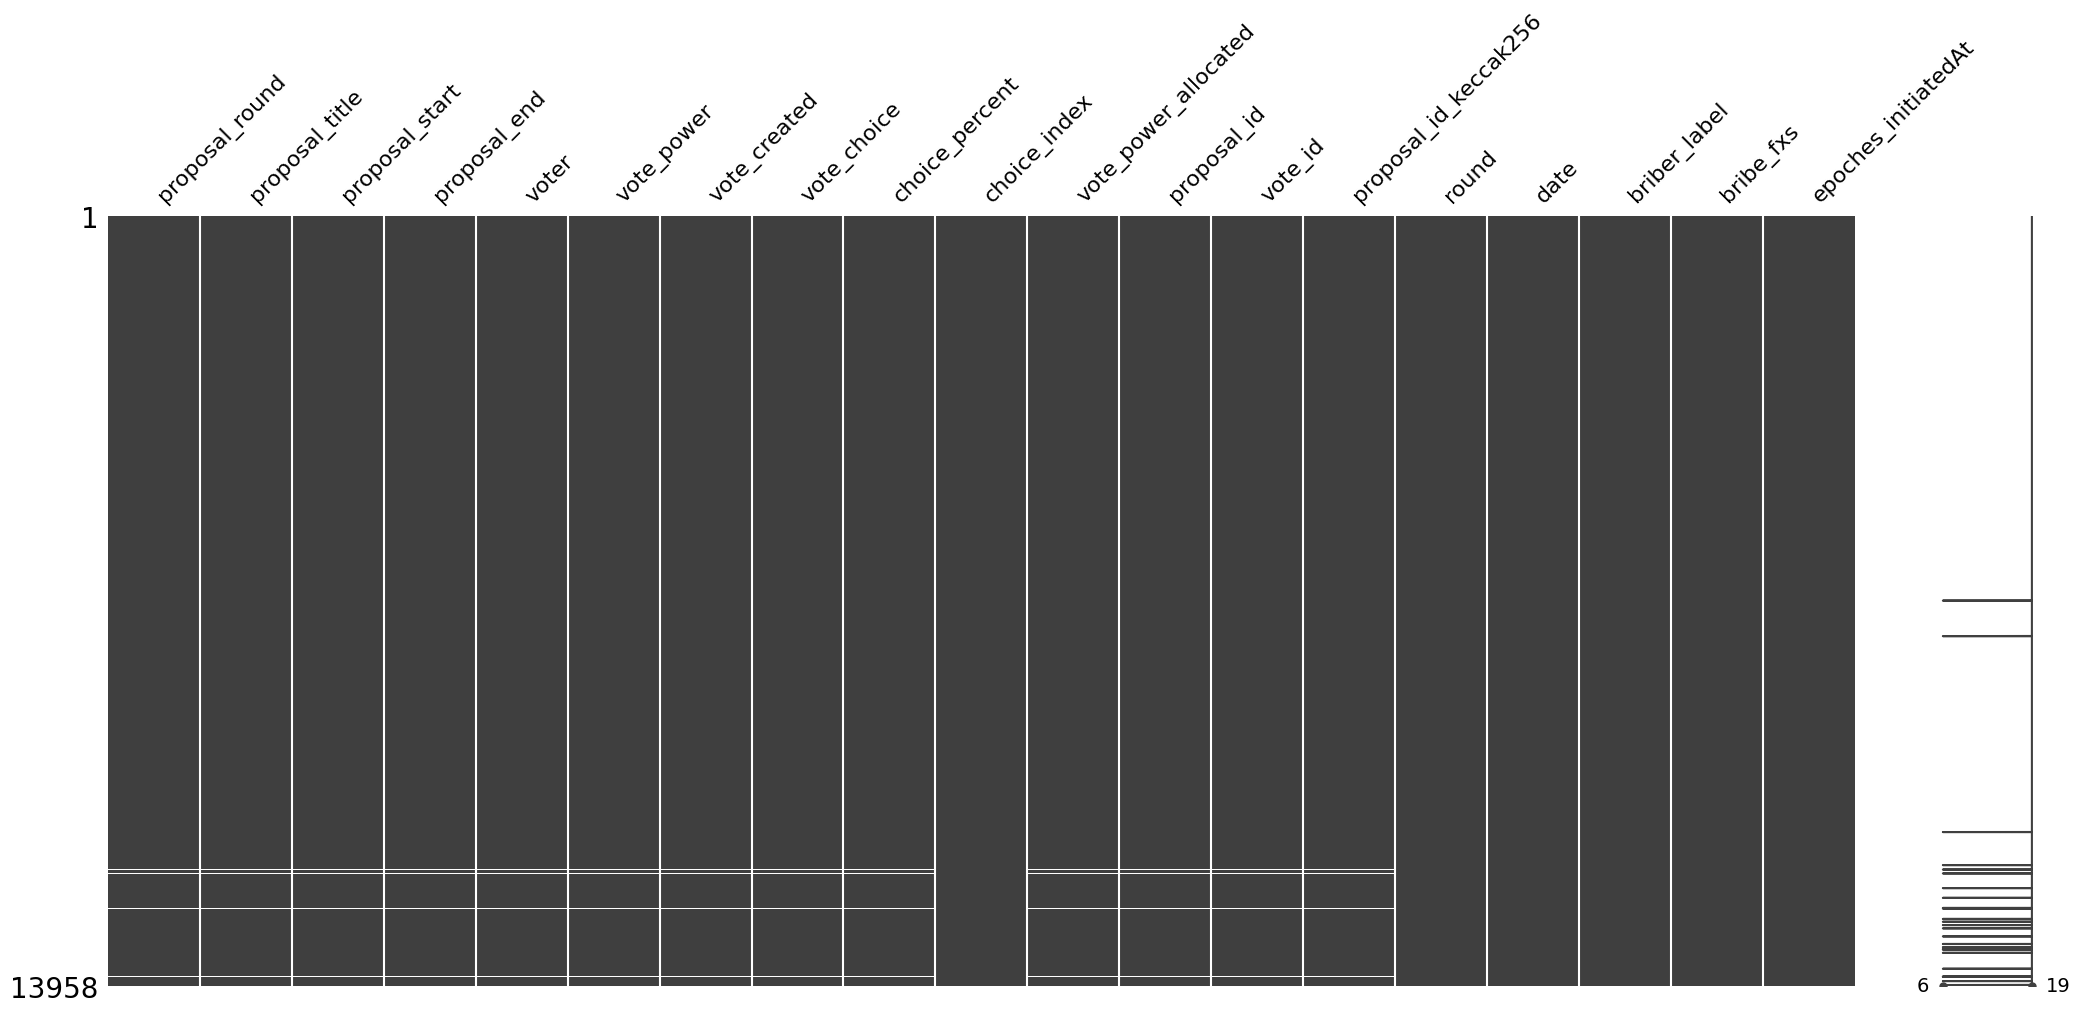

In [35]:
miss.matrix(df)